# Using precalculated samples arrays outside the Brightway2 environment

Pascal Lesage, CIRAIG  
March 2018  

Based on an example published in:  

Lesage, P., C. Mutel, U. Schenker and M. Margni (2018). Uncertainty analysis in LCA using precalculated aggregated datasets. The International Journal of Life Cycle Assessment. https://doi.org/10.1007/s11367-018-1444-x

-----------

## Objectives  
Show how precalculated LCIA arrays generated with the `database_wide_monte_carlo` can be used to calculate LCA scores.  
The example does not use Brightway2.

## Fictional case study - the aluminium water bottle  
 - 150 gram water bottle made of secondary aluminium (new scrap)
 - Cradle-to-gate  
 - Only two unit processes: secondary aluminium, cold-impact extrusion.  
 - Other inputs (such as an interior polymer coating, bottle painting and packaging) are excluded from the simple example.
 - https://www.youtube.com/watch?v=ifl0-re-tV8#t=1m15s  
 - Impact methods of interest: IPCC2013 GWP 100a and ILCD midpoint impacts to human health form ozone layer depletion

## Getting our objects

### Identifying the relevant LCIA arrays

#### Identifying the correct LCIA directory

LCIA arrays are stored in a `results/LCIA` directory. This directory contains subdirectories with names that are hardly human-readable, e.g. `cml-2001ag.0d5f26ea96ba60424b25b2173464ea8b` and `recipe-endpoint-ea-wo-lthp.a4bb73ef1c8b5bb0ca812c7bf571246e`. These are Brightway2-generated abbreviations based in the MD5 hash of the tuple representing the method in Brightway2.  

The helper file `results\reference_files\methods description.xlsx` can be used to identify the map the method of interest to its abbreviation.  From this file, we read that the abbreviations of interest are: 
  - 'ipcc-2013cg.bd5af3f67229a1cc291b8ecb7f316fcf'  
  - 'ilcd-108-2016-midpoint-no-ltho.3039615a2eeeb07c0a5dbc9266b013db'.

In [1]:
import os

In [2]:
LCIA_dir = r'C:/mypy/data/my_mcs/db/results/LCIA'
cc_dir = os.path.join(LCIA_dir, 'ipcc-2013cg.bd5af3f67229a1cc291b8ecb7f316fcf')
o3_dir = os.path.join(LCIA_dir, 'ilcd-108-2016-midpoint-no-ltho.3039615a2eeeb07c0a5dbc9266b013db')

#### Identifying the correct array within the LCIA directory

Now that the LCIA directory is found, we have narrowed it down to as many files as there are activities in the database. In the case of ecoinvent 3.4 cut-off by classification, this means 14889 files! The names of these files are actually just UUIDs, i.e. are not human-readable. 

The helper file `results\reference_files\activity_details.xlsx` can be used to identify the map the activities of interest to their UUID.  From this file, we read the following: 

In [3]:
aluminium_UUID = '752f34fa1a0c7a9c7b2b5d8d52c940e8'
extrusion_UUID = 'f3986f0a13837b31a3130fc4fecc617a'

The full path to the LCIA arrays are therefore, respectively: 

In [4]:
aluminium_fp_cc = os.path.join(cc_dir, aluminium_UUID+'.npy')
aluminium_fp_o3 = os.path.join(o3_dir, aluminium_UUID+'.npy')
extrusion_fp_cc = os.path.join(cc_dir, extrusion_UUID+'.npy')
extrusion_fp_o3 = os.path.join(o3_dir, extrusion_UUID+'.npy')

## LCA calculation with precalculated array

Given the problem description, the LCA score is simply given by:

In [5]:
def score_bottle(score_aluminium, score_extrusion):
    return 0.15 * (score_aluminium + score_extrusion)

Let's load the precalculated arrays. These are stored as numpy arrays, so we need to import numpy:

In [6]:
import numpy as np

In [9]:
aluminium_arr_cc = np.load(aluminium_fp_cc)
extrusion_arr_cc = np.load(extrusion_fp_cc)
aluminium_arr_o3 = np.load(aluminium_fp_o3)
extrusion_arr_o3 = np.load(extrusion_fp_o3)

Let's inspect these objects:  

In [29]:
print("Number of iterations per array: {}".format(aluminium_arr_cc.shape[0]))
print("Format of a value in the array: {}".format(type(aluminium_arr_cc[0])))
print("Size on disk of the array: {} kB".format(os.path.getsize(aluminium_fp_cc)/1000))

Number of iterations per array: 5000
Format of a value in the array: <class 'numpy.float64'>
Size on disk of the array: 40.08 kB


Applying the function to the array of aggregated LCIA scores is then easy and fast:

In [13]:
score_bottle(aluminium_arr_cc, extrusion_arr_cc)

array([ 0.33172825,  0.34000065,  0.34928548, ...,  0.352499  ,
        0.36802129,  0.36512084])

How fast?

In [14]:
% timeit score_bottle(aluminium_arr_cc, extrusion_arr_cc)

6.09 µs ± 775 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


To be fair, we should factor in the time required to load the arrays:

In [15]:
% timeit score_bottle(np.load(aluminium_fp_cc), np.load(extrusion_fp_cc))

694 µs ± 24.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The time went up by a factor of 100, but is still under a millisecond!  

These results can then be plotted: 

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

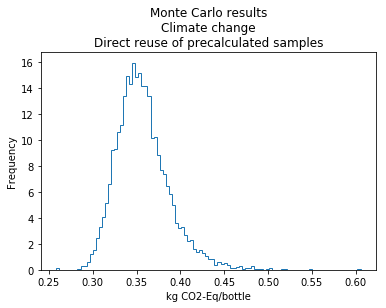

In [25]:
# CC
plt.hist(score_bottle(aluminium_arr_cc, extrusion_arr_cc), histtype='step', bins=100, normed=True)
plt.xlabel("kg CO2-Eq/bottle")
plt.ylabel("Frequency")
plt.legend()
plt.title("Monte Carlo results\nClimate change\nDirect reuse of precalculated samples");

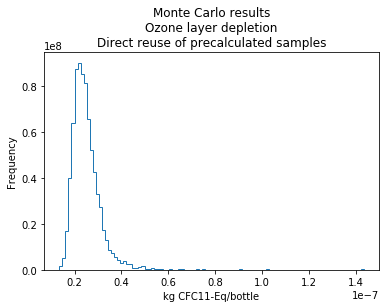

In [23]:
# O3
plt.hist(score_bottle(aluminium_arr_o3, extrusion_arr_o3), histtype='step', bins=100, normed=True)
plt.xlabel("kg CFC11-Eq/bottle")
plt.ylabel("Frequency")
plt.legend()
plt.title("Monte Carlo results\nOzone layer depletion\nDirect reuse of precalculated samples");